In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
from itertools import count
#from models.unet import unet
#from settings import s
import time
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import dataloader
import json
from skimage import color
import matplotlib.pyplot as plt
from matplotlib import path
from tqdm.auto import tqdm

In [5]:
trainset = datasets.STL10(root='../../stl-10', split='train+unlabeled',
                                    download=True, transform=transforms.ToTensor())

Files already downloaded and verified


  0%|▏                                                               | 5537792/2640397119 [00:20<21:33, 2037005.58it/s]

In [8]:
AB=[]

In [14]:
order=np.random.permutation(len(trainset))
for i in tqdm(range(10000)):
    #image=trainloader.dataset.data[i]
    try:
        #image=plt.imread('places-test/Places365_val_%08d.jpg'%i)/255
        image=trainset.data[order[i]]/255
    except FileNotFoundError:
        continue
    labim=color.rgb2lab(image.transpose(1,2,0))
    AB.extend(labim[:,:,1:].reshape(-1,2).tolist())
    #used_bins=dist_mat(bins,labim[:,:,1:].reshape(-1,2)).argmin(0)
    #for j in range(len(used_b

In [15]:
ab=np.array(AB)

In [16]:
ab.shape

(92160000, 2)

In [17]:
bincount=22
H,xe,ye=np.histogram2d(ab[:,0],ab[:,1],bincount)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


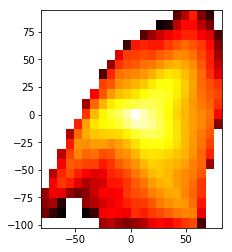

In [18]:
plt.imshow((np.log(H)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
#plt.scatter(*ab[np.random.permutation(len(ab))][:6000].T,s=1)


In [22]:
H[H>0].shape

(340,)

In [23]:
numbin=340
Hpr=np.zeros_like(H)
thres=np.sort(H.flatten())[::-1][numbin]
Hpr[H>thres]=H[H>thres]

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


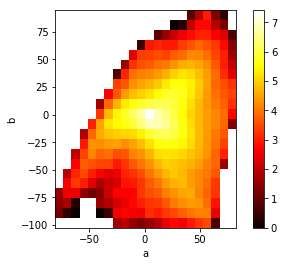

In [24]:
plt.imshow((np.log(Hpr)/np.log(10)),extent=(xe.min(),xe.max(),ye.min(),ye.max()),cmap='hot')
#plt.scatter(*ab[np.random.permutation(len(ab))][:6000].T,s=1)
plt.colorbar()
plt.xlabel('a')
plt.ylabel('b')
plt.savefig('../figures/binfrequency_bigLab.pdf')

In [25]:
binsize=np.array([np.gradient(xe).mean(),np.gradient(ye).mean()])
binsize

array([7.44759023, 8.95765488])

In [26]:
def ind2ab(ind):
    x0=np.array([xe[0],ye[0]])
    return x0+ind*binsize#+binsize/2

In [27]:
x=np.arange(0,bincount)
coord=np.vstack(map(np.ravel, np.meshgrid(x,x))).T

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  


In [28]:
Habfull=ind2ab(coord).reshape(bincount,bincount,2)
Hab=np.zeros_like(Habfull)
Hab[H>thres]=Habfull[H>thres]
bins=Hab[Hab!=np.zeros(2)].reshape(-1,2)

In [30]:
torch.save(torch.from_numpy(bins),'../resources/biglab_bins.pt')

In [33]:
vflag=H>thres
np.save('../resources/biglabhistogram.npy',vflag)

In [23]:
vflag=np.load('../resources/biglabhistogram.npy')

In [62]:
H.shape,x.shape,vflag.shape

((22, 22), (22,), (22, 22))

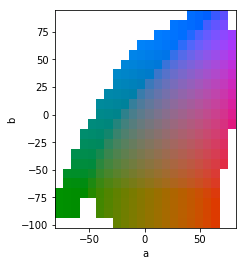

In [34]:
from skimage.transform import pyramid_expand
#plt.figure(figsize=(6,6))
L=np.ones((len(x),len(x),1))*50
labspace=np.concatenate((L,Hab),axis=2)#.transpose(2,1,0)

labspace_w=np.ones_like(labspace)*np.array([100,0,0]).reshape(1,1,3)
labspace_w[vflag.reshape(len(x),len(x))]=labspace[vflag.reshape(len(x),len(x))]
rgbrep=color.lab2rgb(labspace_w)
plt.imshow(rgbrep,extent=(xe.min(),xe.max(),ye.min(),ye.max()))

plt.xlabel('a')
plt.ylabel('b')
#plt.title('Bin colors in ab-space $(L=%i)$'%L.flatten()[0])
#plt.savefig('figures/labgamut-bins.pdf')
bins=labspace[vflag.reshape(len(x),len(x))][:,1:]
for i in range(len(bins)):
    ...#plt.text(bins[i][0],bins[i][1],i)
#plt.scatter(*bins.T)
plt.savefig('../figures/bincolors_biglab.pdf')
plt.show()

In [24]:
class_weight_path = '../resources/probdist_biglab.pt'
weight_lambda=.25
prob_dict = torch.load(class_weight_path)
prob = np.array(list(prob_dict.values()))
weights = 1/((1 - weight_lambda)*prob/prob.sum() + weight_lambda/150)

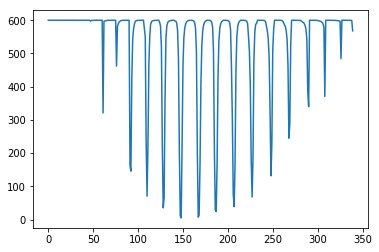

In [25]:
plt.plot(weights)

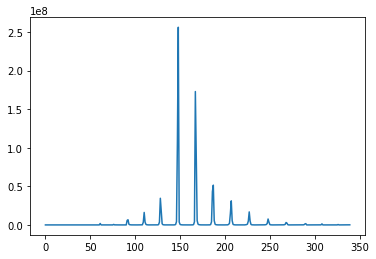

In [30]:
plt.plot(prob)

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0, 0.5, 'b')

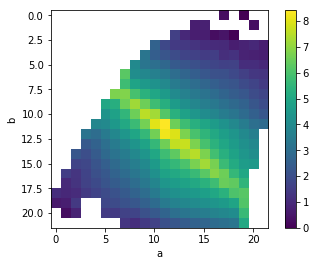

In [35]:
W=np.zeros((22,22))
W[vflag]=prob#weights
#plt.figure(figsize=(6,6))
plt.imshow(np.log(W)/np.log(10))#,extent=(xe.min(),xe.max(),ye.min(),ye.max()))
plt.colorbar()
plt.xlabel('a')
plt.ylabel('b')

abc=bins[3]
plt.imshow(color.yuv2rgb(np.array([.70,abc[0],abc[1]]).reshape(1,1,3)))

In [22]:
from importlib import reload
import functions
reload(functions)
ab2bins=functions.ab2bins

In [23]:
trainset = datasets.CIFAR10(root='./cifar-10', train=True,
                                    download=True, transform=transforms.ToTensor())
im=plt.imread('places-small/Places365_val_00000417.jpg')/255


Files already downloaded and verified


In [24]:
from sklearn.utils import class_weight

In [72]:
count=ab2bins(ab[np.random.permutation(len(ab))[:2000000]],bins[None,...])

In [73]:
np.unique(count).shape

(150,)

In [74]:
weights=class_weight.compute_class_weight('balanced',np.arange(numbin),count.flatten())

In [113]:
torch.save(torch.from_numpy(weights),'resources/class-weights-lab150.pt')

In [84]:
weights=torch.load('resources/class-weights-lab150.pt').numpy()

In [95]:
#weights[weights>13333]=1e4/3

C:\Users\user\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0, 0.5, 'b')

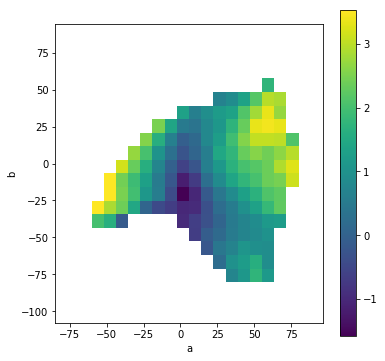

In [111]:
W=np.zeros_like(H)
W[vflag]=weights
plt.figure(figsize=(6,6))
plt.imshow(np.log(W)/np.log(10),extent=(xe.min(),xe.max(),ye.min(),ye.max()))
plt.colorbar()
plt.xlabel('a')
plt.ylabel('b')
#plt.savefig('figures/150labweights.pdf')

In [3]:
def distanceSquaredMatrix(A,B):
    return np.sum(np.square(A[:,None]-B),axis=2)
def K(X1,X2,sig=5):
    dist=distanceSquaredMatrix(X1,X2)
    kernel=np.zeros(dist.shape)
    cutoff=2*sig*np.log(10) #0 when kernel function would be smaller than 0.01
    kernel[dist<cutoff]=np.exp(-dist[dist<cutoff]/(2*sig))
    return kernel

In [2]:
bins=torch.load('../resources/biglab_bins.pt').numpy()

In [17]:
soft=(K(bins,bins,28))

In [19]:
np.count_nonzero(soft,1).mean()

4.729411764705882

In [21]:
torch.save(torch.from_numpy(soft),'../resources/smooth_onehot340.pt')